# ECG classifier

In [11]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [2]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
import os
import pandas as pd

data_path = "../laconeu_final_project/"

for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        if "train" in filename:
            train_path = os.path.join(dirname, filename)
        if "test" in filename:
            test_path = os.path.join(dirname, filename)

In [4]:
train_df = pd.read_csv(train_path, header=None)
test_df = pd.read_csv(test_path, header=None)

In [5]:
# classes
np.unique(train_df.to_numpy()[:,-1])

array([0., 1., 2., 3., 4.])

In [7]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
train_df.shape

(87554, 188)

In [55]:
train_df.to_numpy()[:,:-1]

array([[0.97794116, 0.92647058, 0.68137252, ..., 0.        , 0.        ,
        0.        ],
       [0.96011394, 0.86324787, 0.46153846, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.65945947, 0.18648648, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.90612245, 0.62448978, 0.59591836, ..., 0.        , 0.        ,
        0.        ],
       [0.85822785, 0.64556962, 0.84556961, ..., 0.        , 0.        ,
        0.        ],
       [0.90150636, 0.84588647, 0.80069524, ..., 0.        , 0.        ,
        0.        ]])

In [16]:
def create_data_loader(train_df, test_df, batch_size = 100, val_split=0.3):

    # transform dataframe to numpy array
    train_data = train_df.to_numpy()
    test_data = test_df.to_numpy()
    
    # create x and y
    x_train = train_data[:, :-1]
    x_test = test_data[:, :-1]
    y_train = train_data[:, -1]
    y_test = test_data[:, -1]

    # create tensor dataset of x and y
    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train).float(),
                                                   torch.from_numpy(y_train).long(),)
    test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test).float(),
                                                  torch.from_numpy(y_test).long())
    
    # split dataset in train, val and test
    train_len = train_data.shape[0]
    val_len = int(train_len * val_split)
    train_len -= val_len

    # shuffle train and validade data
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_len, val_len])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

In [17]:
batch_size = 32
val_split = 0.2

In [19]:
train_loader, val_loader, test_loader = create_data_loader(train_df, test_df, batch_size = batch_size, val_split=val_split)

In [20]:
87554//32

2736

In [21]:
len(train_loader)

2189

In [22]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

In [24]:
n_iters = 1000 # number of iterations
num_epochs = 3 # number of training epochs

In [25]:
input_dim = 187   # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 5   # output dimension

# Initiate RNN model
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [26]:
seq_dim = 187  
loss_list = []
iteration_list = []
accuracy_list = []
y_true=[]
y_pred=[]
count = 0
for epoch in range(num_epochs):
    for i, (signals, labels) in enumerate(train_loader):

        train = signals.unsqueeze(1)
        labels = labels.long()
            
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 250 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for signals, labels in val_loader:
                signals = signals.unsqueeze(1)
                
                # Forward propagation
                outputs = model(signals)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            y_true+=labels
            y_pred+=predicted
            if count % 500 == 0:
                # Print validade loss
                print('iteration: {}  val_loss: {}  val_accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  val_loss: 0.5161527991294861  val_accuracy: 88.09252166748047 %
Iteration: 1000  val_loss: 0.20698954164981842  val_accuracy: 88.78926086425781 %
Iteration: 1500  val_loss: 0.25693222880363464  val_accuracy: 90.40547943115234 %
Iteration: 2000  val_loss: 0.2930688261985779  val_accuracy: 91.27926635742188 %
Iteration: 2500  val_loss: 0.3741516172885895  val_accuracy: 92.00457000732422 %
Iteration: 3000  val_loss: 0.16045066714286804  val_accuracy: 92.095947265625 %
Iteration: 3500  val_loss: 0.062214553356170654  val_accuracy: 92.678466796875 %
Iteration: 4000  val_loss: 0.19737812876701355  val_accuracy: 92.49571990966797 %
Iteration: 4500  val_loss: 0.13172562420368195  val_accuracy: 93.86064910888672 %
Iteration: 5000  val_loss: 0.3371700346469879  val_accuracy: 94.15191650390625 %
Iteration: 5500  val_loss: 0.07696567475795746  val_accuracy: 94.28897857666016 %
Iteration: 6000  val_loss: 0.28944072127342224  val_accuracy: 94.38606262207031 %
Iteration: 6500  val_los

In [35]:
# Test model
for signals, labels in test_loader:
    signals = signals.unsqueeze(1)

    # Forward propagation
    outputs = model(signals)

    # Get predictions from the maximum value
    predicted = torch.max(outputs.data, 1)[1]

    # Total number of labels
    total += labels.size(0)

    correct += (predicted == labels).sum()
    
accuracy = 100 * correct / float(total)

# store loss and iteration
# loss_list.append(loss.data)
# accuracy_list.append(accuracy)
y_true+=labels
y_pred+=predicted
# Print validade loss
print('test_accuracy: {} %'.format(accuracy.numpy().round()))

test_accuracy: 94.0 %


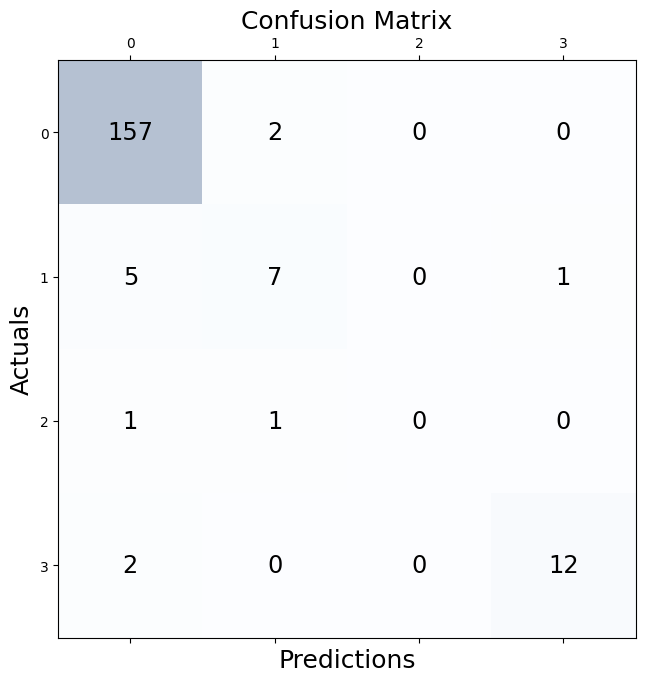

In [36]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

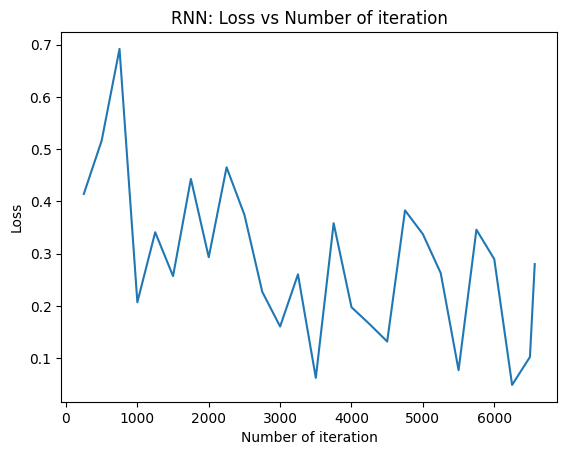

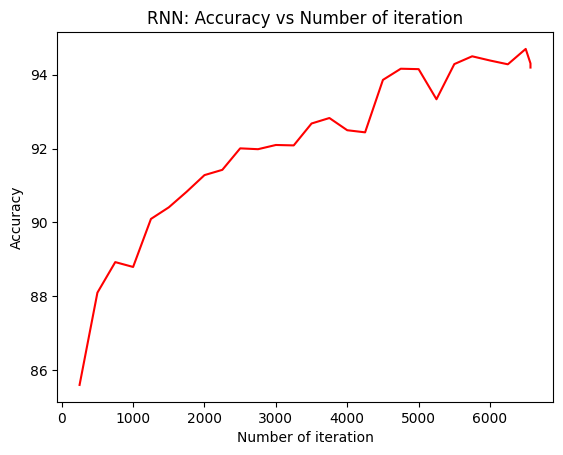

In [37]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()